# 유튜브 조회수 예측하는 의사결정 모델 만들기 :
    - Selenium 및 bs4를 이용하여 해당 링크의 youtube 페이지 크롤링을 한다.
      https://www.youtube.com/channel/UCyn-K7rZLXjGl7VXGweIlcA/videos

    - 기본적인 Decision Tree 모델을 사용하기 위해, 크롤링한 필요정보를 전처리한다.

    - 유튜브 동영상의 제목의 명사 및 형용사에 따라 조회수의 범위를 예측하는 모델 구성한다. 
    

In [8]:
"""
1. 크롤링
"""
# 셀레니움 해당 페이지 접근!
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import time

# youtube 조회수 범위별 그래프 그리기
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import time

#크롬 드라이버를 실행
driver = webdriver.Chrome("chromedriver.exe")
driver.get('https://www.youtube.com/channel/UCyn-K7rZLXjGl7VXGweIlcA/videos')


# 해당 페이지 스크롤 내리기
SCROLL_PAUSE_TIME=0.5
body = driver.find_element_by_tag_name("body")

while True:
    #현재 화면의 길이를 리턴 받아서 last_height에 대입
    last_height=driver.execute_script("return document.documentElement.scrollHeight")
    print("======================================================")
    print("last_height:", last_height)
    
    # 10번 스크롤 내리기
    for i in range(10):
        body.send_keys(Keys.END)
        #SCROLL_PAUSE_TIME에 저장된시간 0.5초 멈춤
        time.sleep(SCROLL_PAUSE_TIME)    
    new_height = driver.execute_script("return document.documentElement.scrollHeight")
    print("new_height:", new_height)
    print("======================================================")

    if new_height == last_height:
        break

#Youtube 페이지 소스를 page에 대입
page = driver.page_source

# bs4 page_source 적용
soup = BeautifulSoup(page,'lxml')

# selenium 종료
driver.quit() 


'''
BeautifulSoup에서 처리!
'''

# video 불러오기
all_videos = soup.find_all(id="dismissable")

title_list = []  # 영상제목 넣을 리스트 선언
for video in all_videos:
    title = video.find(id="video-title")

    if len(title.text.strip())>0:
       title_list.append(title.text)
    
# print(title_list)
# print(len(title_list))


# 비디오 시간 넣기
video_time_list=[]
for video in all_videos:
    video_time = video.find('span',{"class":'style-scope ytd-thumbnail-overlay-time-status-renderer'})
    #비디오 타입의 공백을 제거  video_time.text.strip()
    video_time_list.append(video_time.text.strip())

# 비디오 시간을 int 형으로 처리
video_time_seperate_list=[]
for time in video_time_list:
    time_list=time.split(":")
    #길이가 3미만
    if len(time_list)<3:
        video_time_seperate_list.append(int(time_list[0])*60+int(time_list[1]))
    else: # 영상시간이 시간으로 넘어가는 경우
        video_time_seperate_list.append(int(time_list[0])*3600+int(time_list[1])*60+int(time_list[2]))


# 조회수 조회
view_num_list=[]
import re
#조회수를 포함하는 문자열을 검색하기 위한 객체 view_num_regexp생성
view_num_regexp = re.compile(r'조회수')

for video in all_videos:
    view_num = video.find('span',{"class":'style-scope ytd-grid-video-renderer'})

    if view_num_regexp.search(view_num.text):
        view_num_list.append(view_num.text)

# view_num_list


# 조회수 int형 변환
view_number_type_list=[] # 조회수 를 숫자로 변환해서 저장할 리스트

for view in view_num_list:
    view = view.replace("조회수 ","")
    num = float(view[:-2])
    danwee = view[-2:]
   
    #단위가 "만회"이면
    if danwee=="만회":
        #조회수 숫자에 10000 곱함
        view_number_type_list.append(int(num*10000))
    else:
        #아니면 조회수 숫자에 1000 곱함
        view_number_type_list.append(int(num*1000))


last_height: 2358
new_height: 10868
last_height: 10868
new_height: 12378
last_height: 12378
new_height: 12378


In [9]:
"""
DataFrame 구성 및 유튜브 조회수 예측
"""

'\nDataFrame 구성 및 유튜브 조회수 예측\n'

In [10]:
import pandas as pd

dict_youtube = {"title": title_list, 
"video_time": video_time_seperate_list,
"view_num": view_number_type_list
}

youtube = pd.DataFrame(dict_youtube)
youtube.head() 

,title,video_time,view_num
0,김치전을 바삭바삭하게!,655,450000
1,집에 손님 올 때는 이 메뉴를 해보세요. Make This Dish When You...,821,360000
2,식당에서 먹는 닭볶음탕의 비법은 바로~ What is the secret of Da...,1124,620000
3,장 보러 '서울중앙시장'에 다녀왔습니다! I Went to Seoul Central...,393,230000
4,얼큰하고 매콤하게~ 밥도둑 두부조림! Hot and spicy dubujorim!,520,580000


In [15]:
# 단순한 조회수별 그래프 시각화 해보기
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# 그래프 글꼴 설정!
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

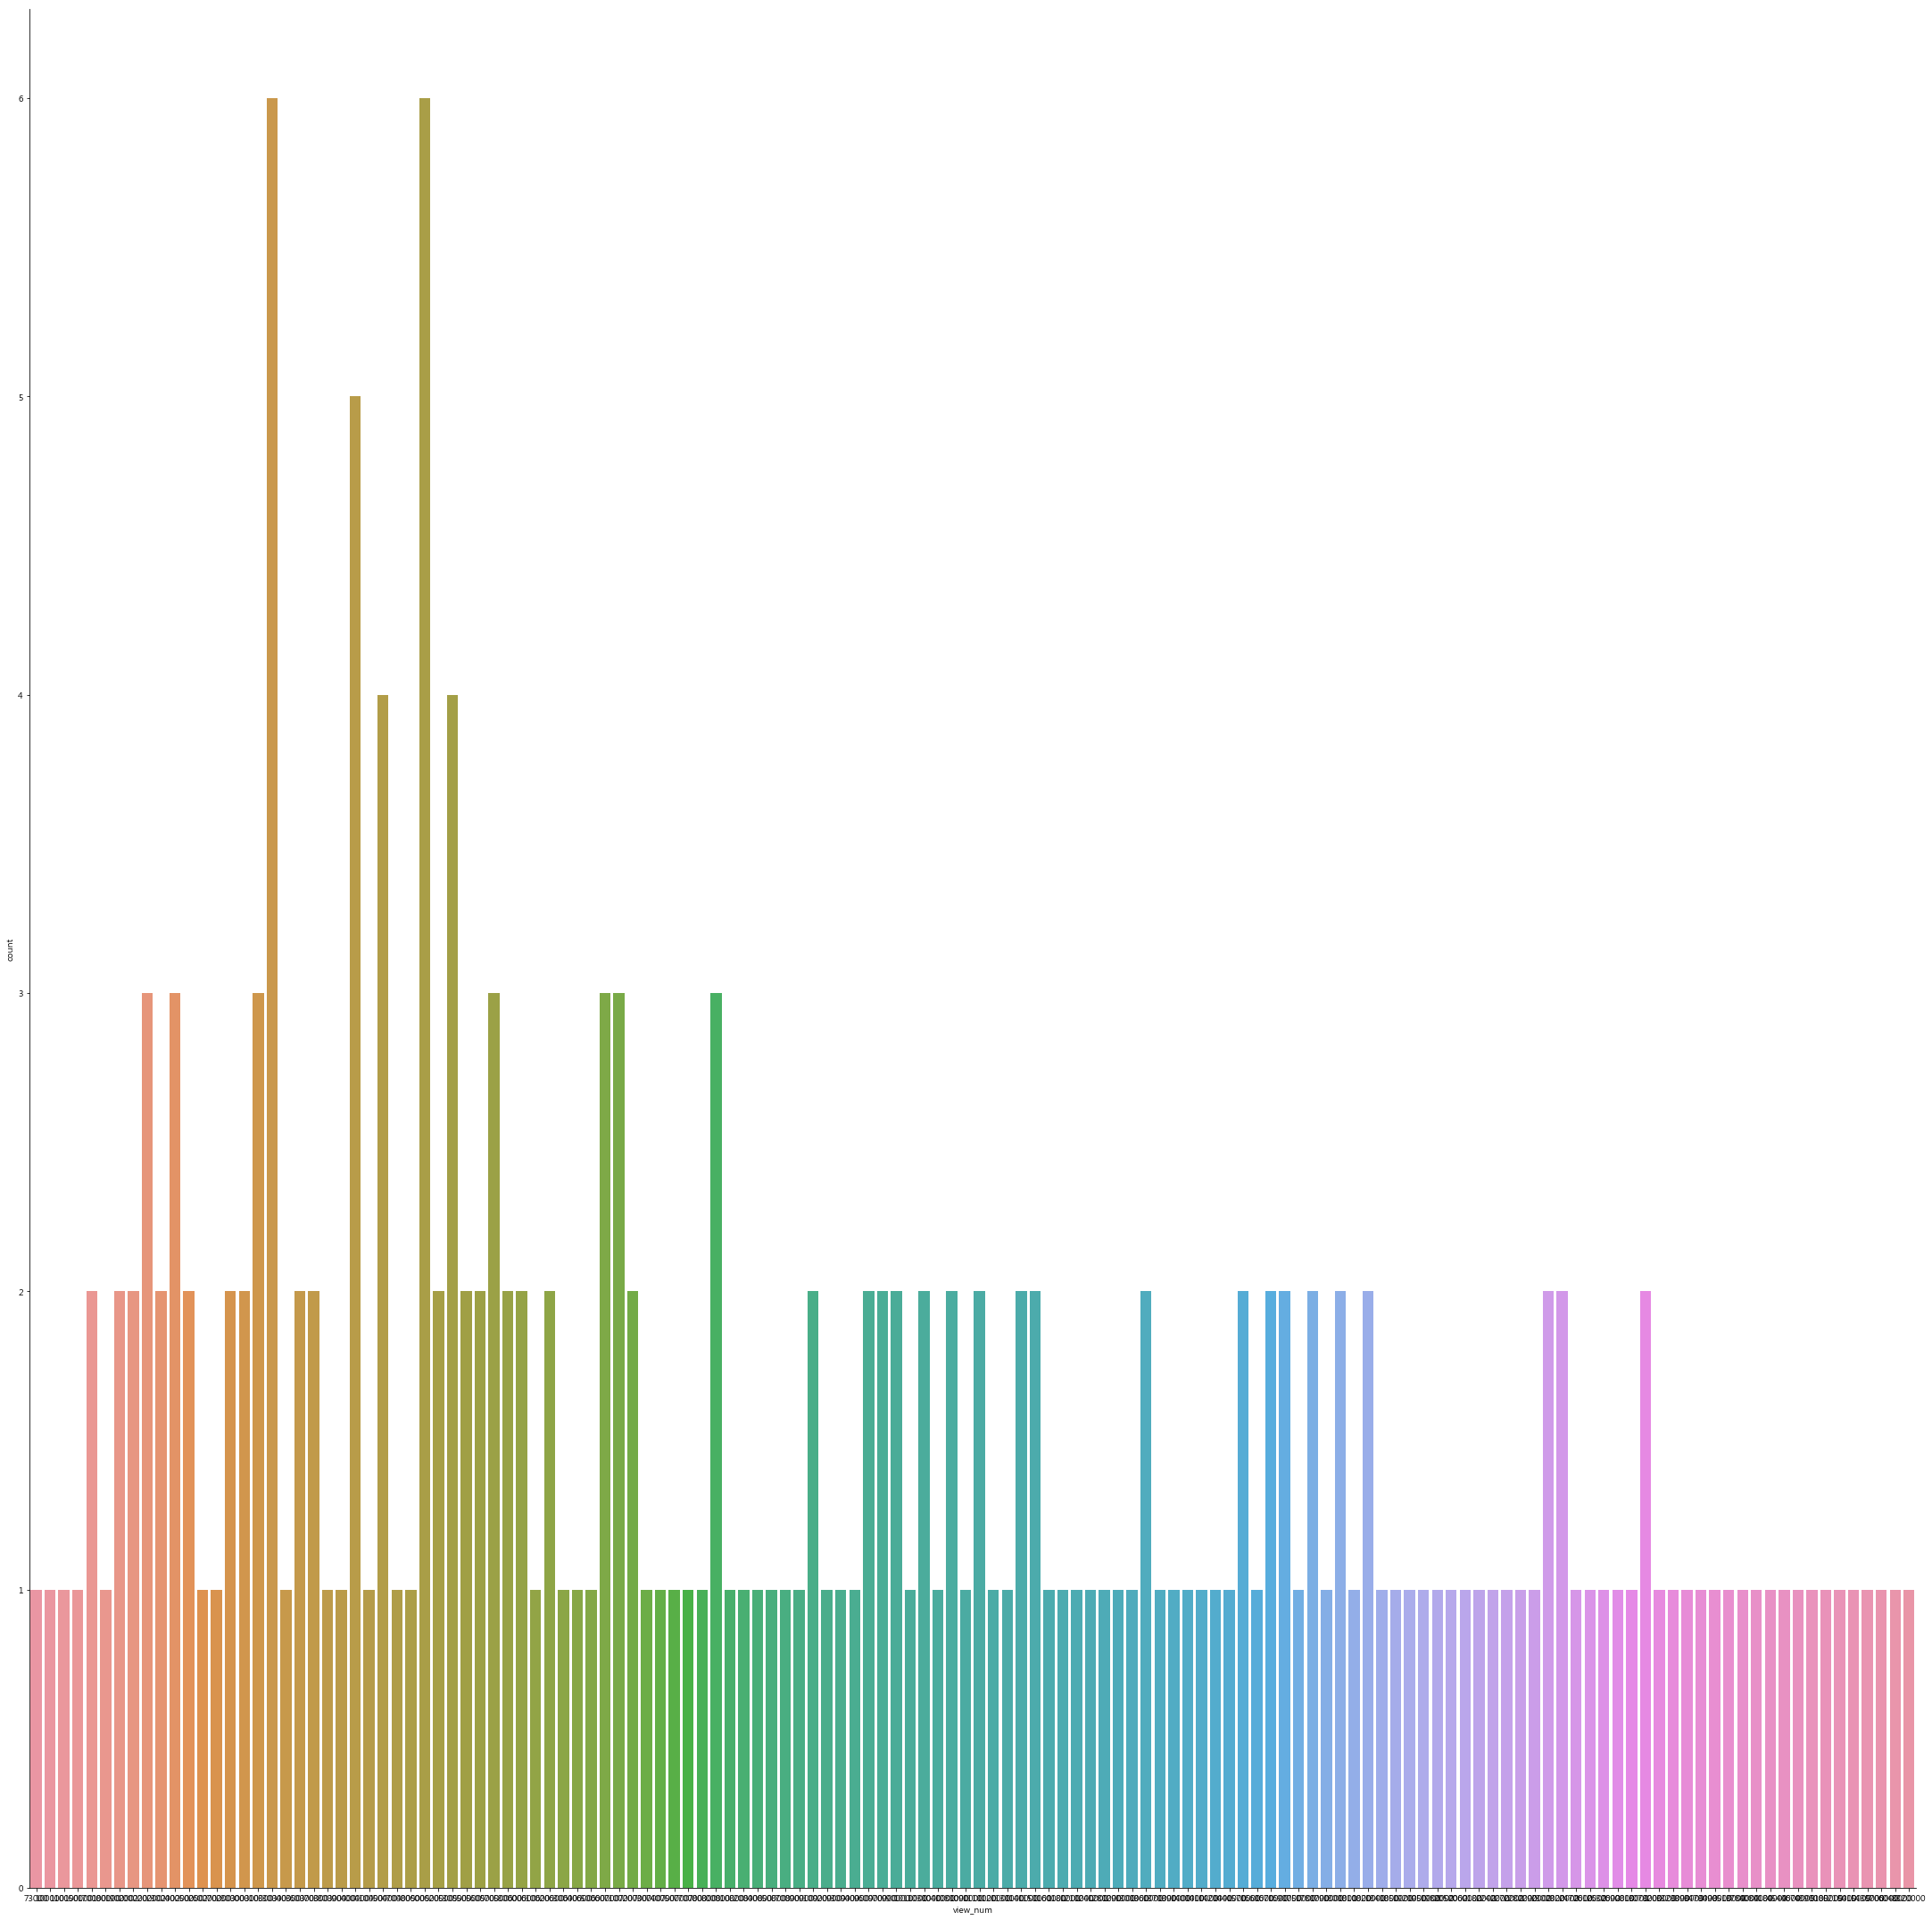

In [17]:
g = sns.factorplot('view_num', data=youtube, kind='count', size=30)
g.set_xlabels()

In [21]:
'''
조회수 범위를 예측하기 위한 종속변수 dataFrame 구성
'''

'\n조회수 범위를 예측하기 위한 종속변수 dataFrame 구성\n'

In [22]:
# 조회수가 null인 줄 삭제
youtube = youtube.dropna(subset=['view_num'])

#view_num2컬럼을 생성하고 0으로 초기화
youtube['view_num2'] = 0
youtube.head()

,title,video_time,view_num,view_num2
0,김치전을 바삭바삭하게!,655,450000,0
1,집에 손님 올 때는 이 메뉴를 해보세요. Make This Dish When You...,821,360000,0
2,식당에서 먹는 닭볶음탕의 비법은 바로~ What is the secret of Da...,1124,620000,0
3,장 보러 '서울중앙시장'에 다녀왔습니다! I Went to Seoul Central...,393,230000,0
4,얼큰하고 매콤하게~ 밥도둑 두부조림! Hot and spicy dubujorim!,520,580000,0


In [23]:
'''
조건:
 1) 50만 미만 = 0
 2) 50만 이상 100만 미만 = 1
 3) 100만 이상 = 2
'''
# 위 조건과 같이 종속변수 dataFrame에 대입하기
for index in range(len(youtube)) :
    #youtube "view_num" 컬럼의 index번째 데이터를 view_num에 대입
    view_num=youtube["view_num"][index]

    if(view_num< 500000 ) :
        #view_num2컬럼에 0 대입
        youtube['view_num2'][index] = 0 

    elif (view_num< 1000000) :
        youtube['view_num2'][index] = 1  

    else :
        youtube['view_num2'][index] = 2
youtube.head()

,title,video_time,view_num,view_num2
0,김치전을 바삭바삭하게!,655,450000,0
1,집에 손님 올 때는 이 메뉴를 해보세요. Make This Dish When You...,821,360000,0
2,식당에서 먹는 닭볶음탕의 비법은 바로~ What is the secret of Da...,1124,620000,1
3,장 보러 '서울중앙시장'에 다녀왔습니다! I Went to Seoul Central...,393,230000,0
4,얼큰하고 매콤하게~ 밥도둑 두부조림! Hot and spicy dubujorim!,520,580000,1


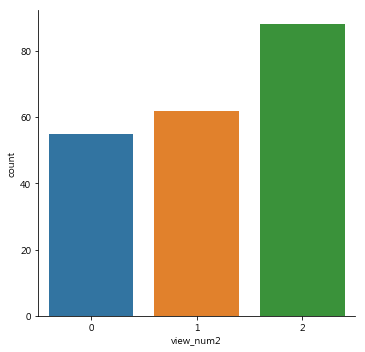

In [24]:
# 설정한 조회수 범위별 그래프 시각화
g = sns.factorplot('view_num2', data=youtube, kind='count', size=5)
g.set_xlabels()

In [25]:
# 학습, 테스트 모델 구성!
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(youtube["title"], youtube["view_num2"])

In [26]:
X_train

1      집에 손님 올 때는 이 메뉴를 해보세요. Make This Dish When You...
151    '외식업이 좋아서 뛰어든 사람들이 상처를 많이 입어요..' 백종원의 장사이야기 34...
145    '갈비찜' 의외로 무지하게 쉽습니다. 이번 추석엔 푸짐한 소갈비찜 요리로 점수 따세...
126    불맛 가득 볶음밥을 더 맛있게! 우리집이 볶음밥 맛집! ㅣ업그레이드 볶음밥 ㅣ 백종...
50                                  집에 있는 재료로 만드는 김치볶음밥!
                             ...                        
149    옥수수로 전 해보셨어요? 캔 옥수수로 뚝딱! 달달, 고소, 바삭! '초간단 옥수수전...
132    사과 농가를 응원합니다! 사과조림으로 만들 수 있는 무궁무진한 활용메뉴들을 확인해 ...
170      [백종원의 장사이야기] 31회 세 번째 '이 집 맛있다'라고 느껴지는 70% 요소는?
95               '내가 가격 낮추면 되지 덜 남으면 좀 어때!' ㅣ 백종원의 장사이야기
47                                       막걸리가 생각나는 '부추전'
Name: title, Length: 153, dtype: object

In [27]:
y_train

1      0
151    0
145    2
126    2
50     2
      ..
149    2
132    2
170    1
95     0
47     2
Name: view_num2, Length: 153, dtype: int64

In [18]:
# 유튜브 동영상 제목의 문장을 단어/품사로 나누어주는 객체
from konlpy.tag import Twitter
twitt = Twitter()

In [19]:
youtube['title'][0]

'김치전을 바삭바삭하게!'

In [20]:
# 단어/품사 출력
tagged = twitt.pos(youtube['title'][0])
tagged

[('김치전', 'Noun'), ('을', 'Josa'), ('바삭바삭하게', 'Adjective'), ('!', 'Punctuation')]

In [30]:
#명사와 형용사만을 리턴하는 함수 정의!
def getNounAndAdject(text):
    stems = []
    tagged = twitt.pos(text,stem=True)
    for i in range (0, len(tagged)): 
        if (tagged[i][1]=='Noun' or tagged[i][1]=='Adjective') :
            stems.append(tagged[i][0])
    return stems

In [31]:
getNounAndAdject("아버지가 방에 들어 가신다 그래서 슬프다")

['아버지', '방', '슬프다']

In [32]:
'''
문자열의 TF(Term Frequency, 빈도수) IDF(중요도)를 계산하는 객체 생성
TF x IDF 연산을 통해 문장의 문자열에서 빈도수별 중요정도를 알 수 있음!
'''
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2, tokenizer=getNounAndAdject) # 최소 value 2개 이상은 갖으면서, 위에 정의한대로 명사/형용사 리턴하는 객체

In [34]:
# 학습데이터의 tfidf를 계산
X_train_vector = vectorizer.fit_transform(X_train)

# 테스트 데이터의 tfidf를 계산
X_test_vector = vectorizer.transform(X_test)

In [35]:
# X_train_vector를 데이터 프레임으로 변환
df_tfidf_X = pd.DataFrame(X_train_vector.A, columns=vectorizer.get_feature_names())
df_tfidf_X

,가게,가족,간단,간단하다,감자,강,거,건,고구마,고기,...,햄,햄버거,호불호,홍어,홍합,화제,확인,환상,활용,회복하다
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.0,0.0,0.312983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
149,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.30758,0.0,0.264408,0.0
150,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
151,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0


In [36]:
# X_test_vector를 데이터 프레임으로 변환
df_tfidf_xt = pd.DataFrame(X_test_vector.A, columns=vectorizer.get_feature_names())
df_tfidf_xt

,가게,가족,간단,간단하다,감자,강,거,건,고구마,고기,...,햄,햄버거,호불호,홍어,홍합,화제,확인,환상,활용,회복하다
0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
5,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.351211,0.0
6,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
7,0.459712,0.0,0.000000,0.0,0.000000,0.000000,0.391195,0.488149,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
8,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
9,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [37]:
# 의사결정모델 사용!
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()

In [38]:
# train 데이터셋의 TF x IDF 연산!
dt_clf = dt_clf.fit(X_train_vector, y_train)

In [39]:
# 예측값 연산
dt_prediction = dt_clf.predict(X_test_vector)
dt_prediction

array([1, 0, 2, 0, 0, 2, 2, 1, 2, 1, 0, 0, 2, 2, 1, 2, 0, 2, 0, 1, 0, 2,
       0, 0, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2,
       0, 2, 1, 0, 0, 0, 0, 2], dtype=int64)

In [40]:
# 테스트셋 정답
y_test

111    1
59     1
75     1
42     2
41     1
186    2
152    2
106    0
172    1
131    2
71     1
133    0
153    2
98     2
195    2
134    1
11     1
173    1
60     2
167    1
196    1
101    2
125    0
53     2
171    2
158    0
100    1
110    2
33     2
162    2
191    1
28     0
78     0
96     0
7      0
27     0
185    2
68     1
25     1
165    2
109    2
192    2
189    2
2      1
56     2
44     2
139    2
0      0
120    2
57     1
140    0
159    2
Name: view_num2, dtype: int64

In [41]:
# 모델의 성능을 평가하기 위한 패키지 불러들임
from sklearn.metrics import  confusion_matrix
confusion_matrix(y_test, dt_prediction)

array([[ 7,  2,  2],
       [ 7,  4,  6],
       [ 6,  4, 14]], dtype=int64)

In [42]:
# 정확도 계산
from sklearn.metrics import  accuracy_score

accuracy = accuracy_score(y_test , dt_prediction)
print("정확도:", accuracy)

정확도: 0.4807692307692308


In [43]:
# graphviz 설정
import os
os.environ["PATH"]+=";c:/ai/program/Graphviz/bin/"
os.environ["PATH"]

'C:\\ProgramData\\Anaconda3\\envs\\test\\lib\\site-packages\\pywin32_system32;C:\\ProgramData\\Anaconda3\\envs\\test;C:\\ProgramData\\Anaconda3\\envs\\test\\Library\\mingw-w64\\bin;C:\\ProgramData\\Anaconda3\\envs\\test\\Library\\usr\\bin;C:\\ProgramData\\Anaconda3\\envs\\test\\Library\\bin;C:\\ProgramData\\Anaconda3\\envs\\test\\Scripts;C:\\ProgramData\\Anaconda3\\envs\\test\\bin;C:\\ProgramData\\Anaconda3\\condabin;C:\\ProgramData\\Anaconda3;C:\\ProgramData\\Anaconda3\\Library\\mingw-w64\\bin;C:\\ProgramData\\Anaconda3\\Library\\usr\\bin;C:\\ProgramData\\Anaconda3\\Library\\bin;C:\\ProgramData\\Anaconda3\\Scripts;C:\\Program Files (x86)\\NAT Service;C:\\ProgramData\\Oracle\\Java\\javapath;C:\\Program Files (x86)\\Common Files\\Intel\\Shared Libraries\\redist\\intel64\\compiler;C:\\Program Files (x86)\\Intel\\iCLS Client\\;C:\\Program Files\\Intel\\iCLS Client\\;C:\\Windows\\system32;C:\\Windows;C:\\Windows\\System32\\Wbem;C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\;C:\\Program F

In [44]:
from sklearn.tree import export_graphviz

export_graphviz(
        dt_clf,
        out_file="youtube_tree.dot",
        feature_names=df_tfidf_X.columns,
        class_names=["bad","normal","good"],
        rounded=True,
        filled=True
    )

In [46]:
! pip install graphviz

In [47]:
import graphviz
with open("youtube_tree.dot", encoding="UTF-8") as f:
    dot_graph = f.read()
    
dot = graphviz.Source(dot_graph,encoding="UTF-8")

dot

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH